IF USING GOOGLE COLAB

In [ ]:
!wget -q https://github.com/lohzhunyewcs/pytorch_boilerplate/archive/refs/heads/base_metrics.zip

In [ ]:
!unzip -q base_code.zip

In [ ]:
!cd pytorch_boilerplate-base_metrics

In [ ]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

In [ ]:
!unzip -q cats_and_dogs_filtered.zip

In [ ]:
!mkdir pytorch_boilerplate-base_metrics/data

In [ ]:
!mv cats_and_dogs_filtered pytorch_boilerplate-base_metrics/data/

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

In [ ]:
!unzip -q hymenoptera_data.zip

In [ ]:
!mkdir pytorch_boilerplate-base_metrics/data

In [ ]:
!mv hymenoptera_data pytorch_boilerplate-base_metrics/data/

In [ ]:
!pip install torcheval

In [ ]:
!pip install torchmetrics

In [ ]:
import sys
sys.path.append('/content/pytorch_boilerplate-base_metrics')

END OF USING GOOGLE COLAB

In [1]:
from models.vision.image_classification.mobilenet import load_model, MobileNetModelsType
from weight_type import WeightType
from task_type import VisionTaskType
from datasets.vision.image_classification import get_dataset_and_dataloader
from datasets.vision.augmentations import create_transforms
from train import train

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import metrics

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [2]:
mode_to_dataset = {}
mode_to_dataloaders = {}
mode_to_datasizes = {}


task = VisionTaskType.ImageClassification

In [3]:
# Data

if IN_COLAB:
    BASE_DATA_PATH = "/content/pytorch_boilerplate-base_metrics/data/hymenoptera_data"
else:
    BASE_DATA_PATH = "data/cats_and_dogs_filtered"#"data/hymenoptera_data"
BATCH_SIZE = 4
IMG_WIDTH = 224
IMG_HEIGHT = 224
for mode in os.listdir(BASE_DATA_PATH):
    is_train = mode == "train"
    mode_data_path = f'{BASE_DATA_PATH}/{mode}'
    cats = os.listdir(mode_data_path)

    gt_to_cat_name = {
        index: cat for index, cat in enumerate(cats)
    }

    cat_to_gt = {
        cat: index for index, cat in enumerate(cats)
    }

    NUM_CLASS = len(cat_to_gt)

    img_transforms = create_transforms(is_train, img_width=IMG_WIDTH, img_height=IMG_HEIGHT, use_random_crop=False)

    # from torchvision import transforms
    # if is_train:
    #     img_transforms = transforms.Compose([
    #         transforms.RandomResizedCrop(224),
    #         transforms.RandomHorizontalFlip(),
    #         transforms.ToTensor(),
    #         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    #     ])
    # else:
    #     img_transforms = transforms.Compose([
    #         transforms.Resize(256),
    #         transforms.CenterCrop(224),
    #         transforms.ToTensor(),
    #         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    #     ])
    
    label_transforms = None
    
    image_paths = []
    gts = []

    for cat in cats:
        cat_data_path = f'{mode_data_path}/{cat}'
        new_image_paths = [
            f'{cat_data_path}/{image_names}' for image_names in os.listdir(cat_data_path) 
            if cv2.imread(f'{cat_data_path}/{image_names}') is not None
        ]
        image_paths += new_image_paths
        gts += [cat_to_gt[cat] for _ in new_image_paths]


    dataset_and_loader_and_size = get_dataset_and_dataloader(
        image_paths, gts, gt_to_cat_name, img_transforms, label_transforms, BATCH_SIZE, shuffle=is_train
    )
    dataset = dataset_and_loader_and_size['dataset']
    dataloader = dataset_and_loader_and_size['dataloader']
    datasize = dataset_and_loader_and_size['datasize']

    mode_to_dataloaders[mode] = dataloader
    mode_to_datasizes[mode] = datasize
    mode_to_dataset[mode] = dataset


# Loss function
if NUM_CLASS == 1:
    criterion = nn.BCEWithLogitsLoss()
else:
    # criterion = nn.NLLLoss()
    criterion = nn.CrossEntropyLoss()

# Metrics
metric_lists = [
    metrics.Precision(NUM_CLASS),
    metrics.Recall(NUM_CLASS),
    metrics.AUC(),
]

c:\Users\ZY\Anaconda3\envs\pytorch_boilerplate\Lib\site-packages\albumentations\augmentations\dropout\cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
c:\Users\ZY\Anaconda3\envs\pytorch_boilerplate\Lib\site-packages\albumentations\core\composition.py:53: UserWarning: transforms is single transform, but a sequence is expected! Transform will be wrapped into list.
  warnings.warn(


In [4]:
criterion

CrossEntropyLoss()

In [5]:

N_EPOCHS = 25
MODEL_SAVE_PATH = f"saved_models/test_image_classification_model"
model = load_model(MobileNetModelsType.mobilenet_v3_small, WeightType.Pretrained, weights_path=None, num_class=NUM_CLASS)

# # # FOR TEST
# import torchvision
# model = torchvision.models.resnet18(pretrained=True)
# num_ftrs = model.fc.in_features
# # Here the size of each output sample is set to 2.
# # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model.fc = nn.Linear(num_ftrs, NUM_CLASS)

# ####


# SGD Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu" )

In [6]:
for mode, dataset in mode_to_dataset.items():
    for img, gt in dataset:
        print(gt.item())
        break

0
0


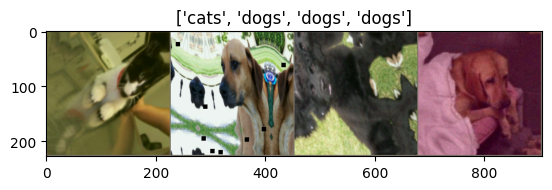

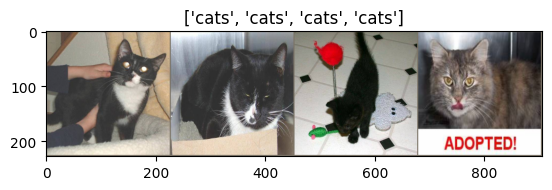

In [7]:
from visualise import visualise_dataloader
for mode, dataloader in mode_to_dataloaders.items():
    visualise_dataloader(dataloader, gt_to_cat_name)

In [8]:
for mode, dataset in mode_to_dataset.items():
    print(f'{mode = }')
    break
    for index in range(len(dataset)):
        if index == 3:
            break
        img_path = dataset.image_paths[-index]
        gt = dataset.gts[-index]
        cv2_img = cv2.imread(img_path)
        cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
        plt.figure()
        plt.imshow(cv2_img)
        plt.draw()
        print(f'{gt_to_cat_name[gt] = }')

mode = 'train'


In [9]:
# import cv2
# # index = 116
# img = cv2.imread('data/hymenoptera_data/train/ants/hormiga_co_por.jpg')
# img.shape

In [10]:
# dataset.img_transforms(image=img)['image'].shape

In [11]:
train(
    model, mode_to_dataloaders, mode_to_datasizes, task=task, 
    num_class=NUM_CLASS, criterion=criterion, optimizer=optimizer, 
    device=device, model_save_folder_path=MODEL_SAVE_PATH, metrics=metric_lists, 
    scheduler=exp_lr_scheduler, n_epochs=N_EPOCHS
)

----------
On n_epoch = 0
Curr Loss = 0.6583, Acc = 0.6055: 100%|██████████| 500/500 [01:54<00:00,  4.35it/s]
train Loss: 0.6583 Acc: 0.6055
Curr Loss = 0.4116, Acc = 0.8780: 100%|██████████| 250/250 [00:08<00:00, 29.43it/s]
val Loss: 0.4116 Acc: 0.8780
mode = 'val' current best_acc = tensor(0.8780, dtype=torch.float64) from best_epoch = 0
Total time taken for this epoch = 123.41488885879517
Total time taken so far = 123.41488885879517
----------
On n_epoch = 1
Curr Loss = 0.5791, Acc = 0.7090: 100%|██████████| 500/500 [01:54<00:00,  4.37it/s]
train Loss: 0.5791 Acc: 0.7090
Curr Loss = 0.3137, Acc = 0.8890: 100%|██████████| 250/250 [00:08<00:00, 29.64it/s]
val Loss: 0.3137 Acc: 0.8890
mode = 'val' current best_acc = tensor(0.8890, dtype=torch.float64) from best_epoch = 1
Total time taken for this epoch = 122.75879907608032
Total time taken so far = 246.17468070983887
----------
On n_epoch = 2
Curr Loss = 0.5266, Acc = 0.7430: 100%|██████████| 500/500 [01:55<00:00,  4.34it/s]
train Loss

KeyboardInterrupt: 

In [ ]:
from train import train_model
train_model(model, criterion, optimizer, exp_lr_scheduler, mode_to_dataloaders, device, mode_to_datasizes)

Epoch 0/24
----------
train Loss: 0.6779 Acc: 0.5779
val Loss: 0.6492 Acc: 0.6471

Epoch 1/24
----------
train Loss: 0.6261 Acc: 0.6844
val Loss: 0.5653 Acc: 0.7908

Epoch 2/24
----------
train Loss: 0.5577 Acc: 0.7828
val Loss: 0.5012 Acc: 0.8497

Epoch 3/24
----------
train Loss: 0.5362 Acc: 0.7459
val Loss: 0.4623 Acc: 0.8627

Epoch 4/24
----------
train Loss: 0.4975 Acc: 0.8197
val Loss: 0.4373 Acc: 0.8693

Epoch 5/24
----------
train Loss: 0.4733 Acc: 0.8197
val Loss: 0.4152 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.4512 Acc: 0.8361
val Loss: 0.3952 Acc: 0.8693

Epoch 7/24
----------
train Loss: 0.4148 Acc: 0.8320
val Loss: 0.3954 Acc: 0.8758

Epoch 8/24
----------
train Loss: 0.4240 Acc: 0.8361
val Loss: 0.3933 Acc: 0.8758

Epoch 9/24
----------
train Loss: 0.4488 Acc: 0.8402
val Loss: 0.3899 Acc: 0.8889

Epoch 10/24
----------
train Loss: 0.4355 Acc: 0.8279
val Loss: 0.3890 Acc: 0.8693

Epoch 11/24
----------
train Loss: 0.3915 Acc: 0.8852
val Loss: 0.3868 Acc: 0.8824

Ep

KeyboardInterrupt: 

gt_to_cat_name[label] = 'ants'


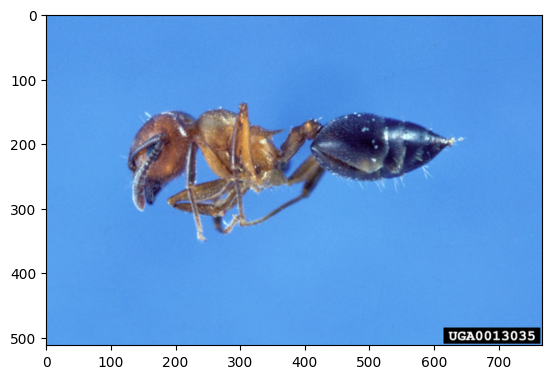

In [11]:
curr_dataset = mode_to_dataset['train']
img, gt = curr_dataset[0]
curr_dataset.debug_mode = True
img_path, label = curr_dataset[0]
curr_dataset.debug_mode = False
cv2_img = cv2.imread(img_path)
cv2_img = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(cv2_img)
print(f'{gt_to_cat_name[label] = }')

In [12]:
mod_output = model(img.unsqueeze(0))
mod_output.shape

torch.Size([1, 2])

In [13]:
mod_output

tensor([[0.0108, 0.0698]], grad_fn=<AddmmBackward0>)

In [47]:
mod_output = torch.tensor([[0.524, 1232131.1]])

In [19]:
torch.softmax(mod_output, dim=1)

tensor([[0.4016, 0.5984]], grad_fn=<SoftmaxBackward0>)

In [48]:
mod_output.shape

torch.Size([1, 2])

In [56]:
mod_output = nn.LogSoftmax(dim=1)(mod_output)

In [52]:
torch.logsoftmax(mod_output, dim=1)

AttributeError: module 'torch' has no attribute 'logsoftmax'

In [14]:
new_gt = gt.unsqueeze(0)
new_gt.shape

torch.Size([1])

In [15]:
new_gt

tensor([0])

In [16]:
criterion(mod_output, new_gt)

tensor(0.7230, grad_fn=<NllLossBackward0>)

In [17]:
criterion(torch.softmax(mod_output, dim=1), new_gt)

tensor(0.7080, grad_fn=<NllLossBackward0>)